<strong><b><font size="5">Data Science Academy</font></b></strong>

<strong><b><font size="5">Análise Estatística e Modelagem Preditiva de Séries Temporais - Em Python</font></b></strong>

<strong><b><font size="5">Aula 26</font></b></strong>

<strong><b><font size="4">Forecast Probabilístico da Média Mensal de Vendas com Redes Neurais Recorrentes Autoregressivas - Modelo DeepAR</font></b></strong>

Todas as aulas deste curso podem ser encontradas na timeline da Comunidade em nosso portal: www.datascienceacademy.com.br/social

O DeepAR, para previsão de demanda, foi lançado pela Amazon, sendo integrado ao SageMaker. Como tal, você pode usar o DeepAR diretamente no Sagemaker na AWS (que é executado como uma caixa preta). 

O que os autores sugerem que, em vez de ajustar modelos separados para cada série temporal, é criar um modelo global a partir de séries temporais relacionadas para lidar com escalas de grande variação por meio de redimensionamento e amostragem baseada em velocidade. Eles usam uma arquitetura RNN (Recurrent Neural Network) que incorpora uma probabilidade gaussiana / binomial negativa para produzir previsão probabilística e supera a previsão tradicional de item único (os autores demonstram isso em vários conjuntos de dados do mundo real). 

A ideia por trás dessa arquitetura é simples: o objetivo aqui é prever a cada etapa o seguinte (horizonte = 1). Isso significa que a rede deve receber na entrada a observação anterior (no atraso = 1) z_t-1, juntamente com um conjunto de covariáveis opcionais x_i. As informações são propagadas para a camada oculta e até a função de verossimilhança (que é uma função de pontuação usada no nível de uma função de perda). A função de probabilidade pode ser binomial gaussiana ou negativa. O erro é calculado usando a parametrização atual da probabilidade. Facilmente, isso é representado por mu e sigma no caso de uma probabilidade gaussiana. Isso significa que, durante a execução do backpropagation, estamos ajustando os parâmetros de rede (pesos w) que alteram a parametrização de todos os exemplos. 

Aqui está o paper do modelo: <a href="https://arxiv.org/abs/1704.04110">DeepAR: Probabilistic Forecasting with Autoregressive Recurrent Networks</a>

O DeepAR pode ser implementado com o **GluonTS**.

Gluon Time Series é uma biblioteca para modelagem de séries temporais baseada em Deep Learning. O GluonTS simplifica o desenvolvimento e a experimentação de modelos de séries temporais para tarefas comuns, como previsão ou detecção de anomalias. Ele fornece todos os componentes e ferramentas necessários que os Cientistas de Dados precisam para criar rapidamente novos modelos, executar e analisar experimentos com eficiência e avaliar a precisão do modelo.

Gluon Time Series (GluonTS) é o kit de ferramentas Gluon para modelagem probabilística de séries temporais, com foco em modelos baseados em Deep Learning.

O GluonTS fornece utilitários para carregar e iterar conjuntos de dados de séries temporais, modelos prontos pré-treinados e blocos de construção para definir seus próprios modelos e experimentar rapidamente soluções diferentes. Com o GluonTS você pode:

- Treinar e avaliar qualquer um dos modelos internos com seus próprios dados e encontrar rapidamente uma solução para suas tarefas de análise de séries temporais.

- Usar abstrações e blocos de construção fornecidos para criar modelos de séries temporais personalizados e fazar uma comparação rápida com os algoritmos de linha de base.

O GluonTS é executado sobre o framework para Deep Learning MxNet, que foi desenvolvido pela Amazon e hoje é um projeto open-source.

Vamos experimentar o GluonTS em nosso problema de séries temporais. Visite o site oficial aqui:

https://gluon-ts.mxnet.io/

Esta aula considera que você já tem alguma noção sobre o que é Deep Learning e a definição de Deep Learning.

Esse conhecimento pode ser obtido no material gratuito fornecido pela DSA, o <a href="http://www.deeplearningbook.com.br/">Deep Learning Book</a>. 

**No Google Colab, altere seu Runtime para executar o treinamento usando GPU**. 

Vamos ao trabalho.

### Carregando os Pacotes Usados Neste Jupyter Notebook

In [1]:
# Para atualizar um pacote, execute o comando abaixo no terminal ou prompt de comando:
# pip install -U nome_pacote

# Para instalar a versão exata de um pacote, execute o comando abaixo no terminal ou prompt de comando:
# pip install nome_pacote==versão_desejada

# Depois de instalar ou atualizar o pacote, reinicie o jupyter notebook, se necessário.

In [2]:
# Instala o pacote watermark. 
# Esse pacote é usado para gravar as versões de outros pacotes usados neste jupyter notebook.
!pip install -q -U watermark

In [3]:
# É preciso atualizar o Statsmodels
!pip install -q -U statsmodels

In [4]:
# Instala o pacote mxnet
!pip install -q mxnet

In [5]:
# Instala o pacote gluonts
!pip install -q gluonts

In [6]:
# As novas versões do Pandas e Matplotlib trazem diversas mensagens de aviso ao desenvolvedor. Vamos desativar isso.
import sys
import warnings
import matplotlib.cbook
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=matplotlib.cbook.mplDeprecation)

# Imports para manipulação de dados
import math
import numpy as np
import pandas as pd
import itertools
from pandas import Series
from pandas.tseries.offsets import DateOffset

# Imports para visualização de dados
import matplotlib.pyplot as plt
import matplotlib as m
import seaborn as sns

# Imports para modelagem preditiva
import statsmodels
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.stats as sms
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

# MxNet / GluonTS
import mxnet
import gluonts
from mxnet import gpu, cpu
from mxnet.context import num_gpus
from gluonts.dataset.common import ListDataset
from gluonts.trainer import Trainer
from gluonts.dataset.util import to_pandas
from gluonts.model.deepar import DeepAREstimator
from gluonts.distribution.neg_binomial import NegativeBinomialOutput
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import Evaluator

# Imports para formatação dos gráficos
m.rcParams['text.color'] = 'k'
from matplotlib.pylab import rcParams 
%matplotlib inline

INFO:root:Using CPU


In [7]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Data Science Academy" --iversions

seaborn         0.10.1
statsmodels.api 0.11.1
numpy           1.18.4
gluonts         0.4.3
pandas          0.25.3
mxnet           1.6.0
matplotlib      3.2.1
statsmodels     0.11.1
Data Science Academy


## Definição do Problema de Negócio

A HappyMoonVC é uma Venture Capital (VC).

Além do investimento no GoInRail (descrito nas aulas anteriores), a HappyMoonVC está analisando um outro negócio. Uma rede de varejo que poderá fornecer produtos para os clientes do GoInRail (drone elétrico para transporte de passageiros). 

Um monitor touch-screen dentro do GoInRail permitiria que o cliente fizesse a compra de produtos enquanto faz a viagem, com a opção de pegar o produto na estação que for descer ou então receber direto na residência (se acha que isso é futurista demais, saiba que já existe no metrô do Japão).

Para decidir se o investimento vale a pena, a HappyMoonVC precisa prever o volume de vendas.  

Esse é nosso trabalho.

## Conjunto de Dados

Usaremos conjuntos de dados que está disponível publicamente no site do Tableau e que representa as vendas históricas da empresa na qual a HappyMoonVC pretende investir. Aqui o link do dataset (que está sendo fornecido para você):

https://community.tableau.com/docs/DOC-1236

De todos os dados disponíveis, nosso interesse é na categoria de produtos de tecnologia.

In [8]:
# Carrega os dados
dados = pd.read_csv('https://raw.githubusercontent.com/dsacademybr/Datasets/master/dataset6.csv')

In [9]:
# Shape
dados.shape

(9994, 21)

In [10]:
# Colunas
dados.columns

Index(['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State',
       'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category',
       'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit'],
      dtype='object')

### Análise Exploratória

In [11]:
# Visualizando os dados
dados.head(3)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.96,2,0.0,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.94,3,0.0,219.5820
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.62,2,0.0,6.8714


In [12]:
# Resumo estatístico
dados.describe()

,Row ID,Postal Code,Sales,Quantity,Discount,Profit
count,9994.000000,9994.000000,9994.000000,9994.000000,9994.000000,9994.000000
mean,4997.500000,55190.379428,229.858001,3.789574,0.156203,28.656896
std,2885.163629,32063.693350,623.245101,2.225110,0.206452,234.260108
min,1.000000,1040.000000,0.444000,1.000000,0.000000,-6599.978000
25%,2499.250000,23223.000000,17.280000,2.000000,0.000000,1.728750
50%,4997.500000,56430.500000,54.490000,3.000000,0.200000,8.666500
75%,7495.750000,90008.000000,209.940000,5.000000,0.200000,29.364000
max,9994.000000,99301.000000,22638.480000,14.000000,0.800000,8399.976000


In [13]:
# Checando valores missing - não temos valores missing no dataset
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
Row ID           9994 non-null int64
Order ID         9994 non-null object
Order Date       9994 non-null object
Ship Date        9994 non-null object
Ship Mode        9994 non-null object
Customer ID      9994 non-null object
Customer Name    9994 non-null object
Segment          9994 non-null object
Country          9994 non-null object
City             9994 non-null object
State            9994 non-null object
Postal Code      9994 non-null int64
Region           9994 non-null object
Product ID       9994 non-null object
Category         9994 non-null object
Sub-Category     9994 non-null object
Product Name     9994 non-null object
Sales            9994 non-null float64
Quantity         9994 non-null int64
Discount         9994 non-null float64
Profit           9994 non-null float64
dtypes: float64(3), int64(3), object(15)
memory usage: 1.6+ MB


In [14]:
# Ajustando o nome das colunas para que todas fiquem com letras minúsculas
dados.columns = map(str.lower, dados.columns)

In [15]:
# Vamos substituir os espaços e traços nos nomes das colunas por '_'
dados.columns = dados.columns.str.replace(" ", "_")
dados.columns = dados.columns.str.replace("-", "_")

In [16]:
# Conferindo
dados.columns

Index(['row_id', 'order_id', 'order_date', 'ship_date', 'ship_mode',
       'customer_id', 'customer_name', 'segment', 'country', 'city', 'state',
       'postal_code', 'region', 'product_id', 'category', 'sub_category',
       'product_name', 'sales', 'quantity', 'discount', 'profit'],
      dtype='object')

Vamos separar os dados por categoria (Móveis, Tecnologia, Material de escritório).

In [17]:
# Separando os dados por categoria
df_tecnologia = dados.loc[dados['category'] == 'Technology']
df_moveis = dados.loc[dados['category'] == 'Furniture']
df_office = dados.loc[dados['category'] == 'Office Supplies']

Agora vamos preparar as séries temporais.

In [18]:
# Agregando as vendas pela data do pedido
ts_tecnologia = df_tecnologia.groupby('order_date')['sales'].sum().reset_index()
ts_moveis = df_moveis.groupby('order_date')['sales'].sum().reset_index()
ts_office = df_office.groupby('order_date')['sales'].sum().reset_index()

Acesse o <a href="http://datascienceacademy.com.br/blog/">Blog da DSA</a> e fique por dentro das novidades em Data Science, Big Data, IA, RPA, Blockchain e mercado de trabalho.

In [19]:
# Como está ficando o nosso dataset de interesse?
ts_tecnologia

,order_date,sales
0,2014-01-06,1147.940
1,2014-01-09,31.200
2,2014-01-13,646.740
3,2014-01-15,149.950
4,2014-01-16,124.200
...,...,...
819,2017-12-25,401.208
820,2017-12-27,164.388
821,2017-12-28,14.850
822,2017-12-29,302.376


Vamos mover a data para o índice e assim criar a série temporal.

In [20]:
# Colocando a data como índice
ts_tecnologia = ts_tecnologia.set_index('order_date')

In [21]:
# Visualizando a série
ts_tecnologia

,sales
order_date,
2014-01-06,1147.940
2014-01-09,31.200
2014-01-13,646.740
2014-01-15,149.950
2014-01-16,124.200
...,...
2017-12-25,401.208
2017-12-27,164.388
2017-12-28,14.850


Agora podemos conferir a performance de vendas ao longo do tempo.

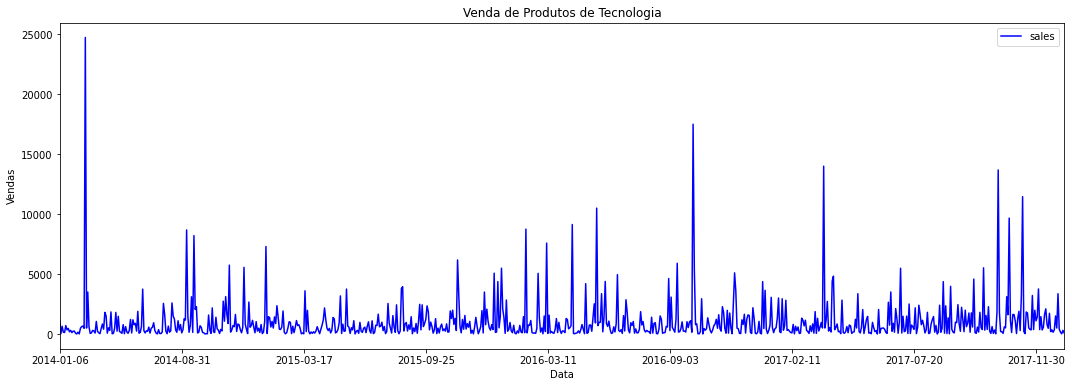

In [22]:
# Venda de Produtos de Tecnologia
vendas_tecnologia = ts_tecnologia[['sales']]
ax = vendas_tecnologia.plot(color = 'b', figsize = (18,6))
plt.xlabel("Data")
plt.ylabel('Vendas')
plt.title("Venda de Produtos de Tecnologia")
plt.show()

Vamos ajustar o indice do tipo Index para o tipo DateTimeIndex (o que caracteriza uma série temporal), pois faremos uma agregação pela média para analisar a venda média ao longo do tempo. 

In [23]:
# Conferindo o tipo do índice
type(vendas_tecnologia.index)

pandas.core.indexes.base.Index

In [24]:
# Alterando o tipo do índice
vendas_tecnologia.index = pd.to_datetime(vendas_tecnologia.index)

In [25]:
# Conferindo o tipo do índice
type(vendas_tecnologia.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [26]:
# Reamostrando os dados para frequência mensal
# Usando o valor médio das vendas diárias - definimos o mês como índice
media_vendas_tecnologia = vendas_tecnologia['sales'].resample('MS').mean()

In [27]:
# Verificando o tipo resultante
type(media_vendas_tecnologia)

pandas.core.series.Series

In [28]:
# Checando os dados
media_vendas_tecnologia

order_date
2014-01-01     449.041429
2014-02-01     229.787143
2014-03-01    2031.948375
2014-04-01     613.028933
2014-05-01     564.698588
2014-06-01     766.905909
2014-07-01     533.608933
2014-08-01     708.435385
2014-09-01    2035.838133
2014-10-01     596.900900
2014-11-01    1208.056320
2014-12-01    1160.732889
2015-01-01     925.070800
2015-02-01     431.121250
2015-03-01     574.662333
2015-04-01     697.559500
2015-05-01     831.642857
2015-06-01     429.024400
2015-07-01     691.397733
2015-08-01    1108.902286
2015-09-01     950.856400
2015-10-01     594.716111
2015-11-01    1037.982652
2015-12-01    1619.637636
2016-01-01     374.671067
2016-02-01    1225.891400
2016-03-01    1135.150105
2016-04-01     875.911882
2016-05-01    1601.816167
2016-06-01    1023.259500
2016-07-01     829.312500
2016-08-01     483.620100
2016-09-01    1144.170300
2016-10-01    1970.835875
2016-11-01    1085.642360
2016-12-01     970.554870
2017-01-01    1195.218071
2017-02-01     430.501714
2

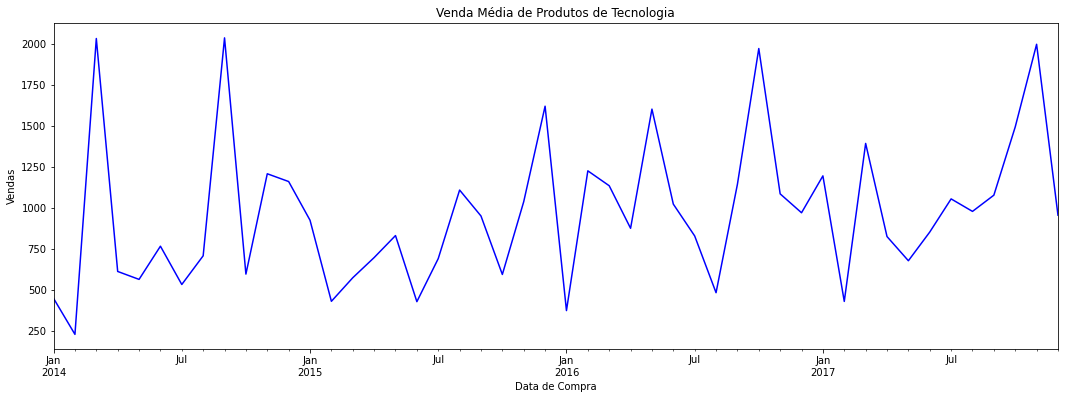

In [29]:
# Venda Média de Produtos de Tecnologia
media_vendas_tecnologia.plot(figsize = (18, 6), color = 'blue')
plt.xlabel("Data de Compra")
plt.ylabel('Vendas')
plt.title("Venda Média de Produtos de Tecnologia")
plt.show()

Agora, vamos decompor uma das séries para avaliar seus componentes.

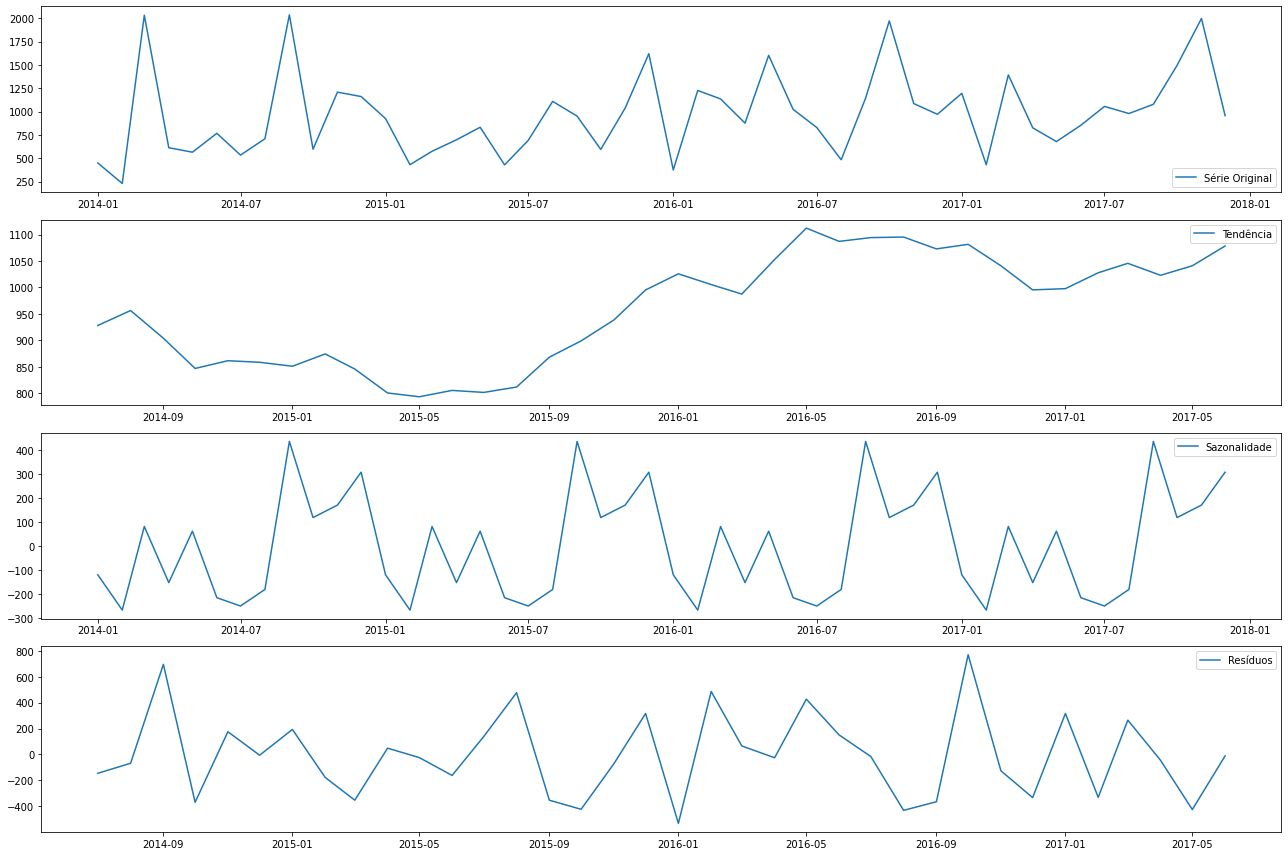

In [30]:
# Decomposição da série temporal de venda média de produtos de tecnologia
decomposition = seasonal_decompose(media_vendas_tecnologia, period = 12)
rcParams['figure.figsize'] = 18, 12

# Componentes
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot
plt.subplot(411)
plt.plot(media_vendas_tecnologia, label = 'Série Original')
plt.legend(loc = 'best')
plt.subplot(412)
plt.plot(trend, label = 'Tendência')
plt.legend(loc = 'best')
plt.subplot(413)
plt.plot(seasonal, label = 'Sazonalidade')
plt.legend(loc = 'best')
plt.subplot(414)
plt.plot(residual, label = 'Resíduos')
plt.legend(loc = 'best')
plt.tight_layout()

Vamos testar a estacionaridade.

In [31]:
# Função para testar a estacionaridade
def testa_estacionaridade(serie):
    
    # Calcula estatísticas móveis
    rolmean = serie.rolling(window = 12).mean()
    rolstd = serie.rolling(window = 12).std()

    # Plot das estatísticas móveis
    plt.figure(figsize = (20, 6))
    orig = plt.plot(serie, color = 'blue', label = 'Original')
    mean = plt.plot(rolmean, color = 'red', label = 'Média Móvel')
    std = plt.plot(rolstd, color = 'black', label = 'Desvio Padrão')
    plt.legend(loc = 'best')
    plt.title('Estatísticas Móveis - Média e Desvio Padrão')
    plt.show()
    
    # Teste Dickey-Fuller:
    # Print
    print('\nResultado do Teste Dickey-Fuller:\n')

    # Teste
    dfteste = adfuller(serie, autolag = 'AIC')

    # Formatando a saída
    dfsaida = pd.Series(dfteste[0:4], index = ['Estatística do Teste',
                                               'Valor-p',
                                               'Número de Lags Consideradas',
                                               'Número de Observações Usadas'])

    # Loop por cada item da saída do teste
    for key, value in dfteste[4].items():
        dfsaida['Valor Crítico (%s)'%key] = value

    # Print
    print (dfsaida)
    
    # Testa o valor-p
    print ('\nConclusão:')
    if dfsaida[1] > 0.05:
        print('\nO valor-p é maior que 0.05 e, portanto, não temos evidências para rejeitar a hipótese nula.')
        print('Essa série provavelmente não é estacionária.')
    else:
        print('\nO valor-p é menor que 0.05 e, portanto, temos evidências para rejeitar a hipótese nula.')
        print('Essa série provavelmente é estacionária.')

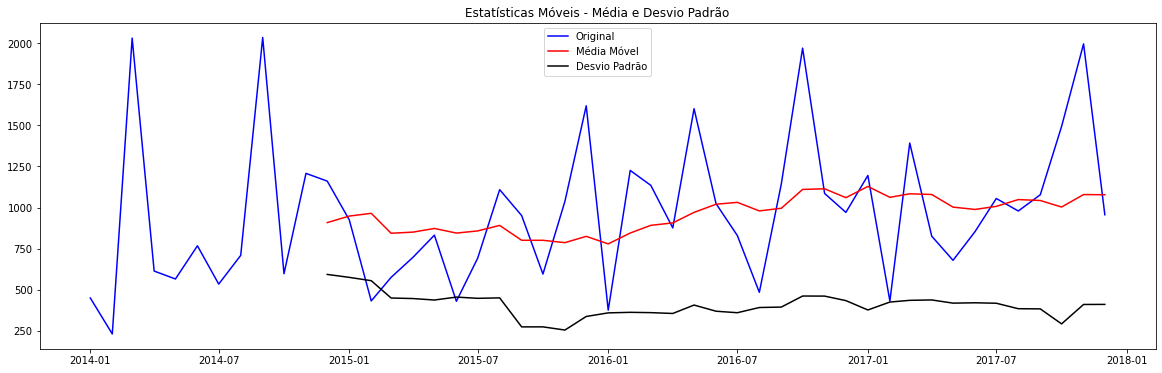


Resultado do Teste Dickey-Fuller:

Estatística do Teste           -7.187969e+00
Valor-p                         2.547334e-10
Número de Lags Consideradas     0.000000e+00
Número de Observações Usadas    4.700000e+01
Valor Crítico (1%)             -3.577848e+00
Valor Crítico (5%)             -2.925338e+00
Valor Crítico (10%)            -2.600774e+00
dtype: float64

Conclusão:

O valor-p é menor que 0.05 e, portanto, temos evidências para rejeitar a hipótese nula.
Essa série provavelmente é estacionária.


In [32]:
# Verifica se a série é estacionária
testa_estacionaridade(media_vendas_tecnologia)

### Dividindo os Dados em Treino e Teste

In [33]:
X = pd.DataFrame(media_vendas_tecnologia)

In [34]:
type(X)

pandas.core.frame.DataFrame

In [35]:
# Os primeiros 36 registros da série serão usados como dados de treino
X[:-12]

,sales
order_date,
2014-01-01,449.041429
2014-02-01,229.787143
2014-03-01,2031.948375
2014-04-01,613.028933
2014-05-01,564.698588
2014-06-01,766.905909
2014-07-01,533.608933
2014-08-01,708.435385
2014-09-01,2035.838133


In [36]:
# Os últimos 12 registros da série serão usados como dados de teste
X[-12:]

,sales
order_date,
2017-01-01,1195.218071
2017-02-01,430.501714
2017-03-01,1392.859250
2017-04-01,825.559133
2017-05-01,678.329400
2017-06-01,853.055000
2017-07-01,1054.996636
2017-08-01,978.842333
2017-09-01,1077.704120


In [37]:
# Ajusta o shape, pois agora não temos um objeto pd.Series, 
# mas sim um array NumPy, que é necessário para treinar o modelo LSTM
trainset = X[:-12]
testset = X[-12:]

In [38]:
len(trainset)

36

In [39]:
trainset

,sales
order_date,
2014-01-01,449.041429
2014-02-01,229.787143
2014-03-01,2031.948375
2014-04-01,613.028933
2014-05-01,564.698588
2014-06-01,766.905909
2014-07-01,533.608933
2014-08-01,708.435385
2014-09-01,2035.838133


In [40]:
len(testset)

12

In [41]:
testset

,sales
order_date,
2017-01-01,1195.218071
2017-02-01,430.501714
2017-03-01,1392.859250
2017-04-01,825.559133
2017-05-01,678.329400
2017-06-01,853.055000
2017-07-01,1054.996636
2017-08-01,978.842333
2017-09-01,1077.704120


### Função Para o Plot do Forecast

In [42]:
# Função
def plot_forecast(predictor, test_data):
    for test_entry, forecast in zip(test_data, predictor.predict(test_data)):
        to_pandas(test_entry).plot(linewidth = 2)
        forecast.plot(color = 'g', prediction_intervals = [50.0, 90.0])
    plt.grid(which = 'both')

Acesse o <a href="http://datascienceacademy.com.br/blog/">Blog da DSA</a> e fique por dentro das novidades em Data Science, Big Data, IA, RPA, Blockchain e mercado de trabalho.

**Preparando o Dataset para o GluonTS**

O GluonTS não requer um formato específico para um conjunto de dados. Os únicos requisitos são dados iteráveis e ter um campo "target" e "start", onde start representa o ponto inicial do índice da série (que é a data) e target o valor final da série. Só isso.

Aqui estamos usando `gluonts.dataset.common.ListDataset`. Passamos **start** como `pandas.index` e **target** como um conjunto iterável de valores do nosso dataframe pandas, coluna sales.

In [43]:
# Dataset de treino para o GluonTS
training_data = ListDataset([{"start": trainset.index[0], 
                              "target": trainset.sales[: "2016-12-01"]}], 
                            freq = "M")

In [44]:
# Dataset de teste para o GluonTS
test_data = ListDataset([{"start": testset.index[0], 
                           "target": testset.sales[:"2017-12-01"]}], 
                        freq = "M")

**Criando o Modelo:**

Um objeto estimador representa a rede e contém um treinador, que inclui tamanho do lote, inicializador, contexto, taxa de aprendizado e outros hiperparâmetros específicos do treinamento. 

O objeto estimador também inclui a frequência do registro de data e hora, o comprimento da previsão para expressar quantas etapas queremos prever e parâmetros estruturais, como o número de camadas. 

O estimador também inclui crucialmente um método de "treino". O método treino é usado para ajustar um modelo a um determinado conjunto de dados e criando assim um objeto preditivo, que pode ser usado para prever valores.

Nos exemplos a seguir, criamos um estimador DeepAR. Para mais informações sobre o DeepAR, consulte o paper (https://arxiv.org/abs/1704.04110) com base no qual o modelo está sendo desenvolvido.

In [45]:
# Criação do modelo
# https://gluon-ts.mxnet.io/api/gluonts/gluonts.model.deepar.html
modelo_gluonts = DeepAREstimator(freq = "M", 
                                 prediction_length = 12, 
                                 distr_output = NegativeBinomialOutput(),
                                 num_layers = 3,
                                 trainer = Trainer(learning_rate = 1e-3, 
                                                   epochs = 500,
                                                   num_batches_per_epoch = 50,
                                                   batch_size = 32))

INFO:root:Using CPU


In [46]:
# Agora fazemos o treinamento
modelo_gluonts_predictor = modelo_gluonts.train(training_data = training_data)

INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/50 [00:00<?, ?it/s]INFO:numexpr.utils:Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:root:Number of parameters in DeepARTrainingNetwork: 36403


learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|██████████| 50/50 [00:01<00:00, 34.69it/s, avg_epoch_loss=7.91]
INFO:root:Epoch[0] Elapsed time 1.443 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.908975
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 37.94it/s, avg_epoch_loss=7.34]
INFO:root:Epoch[1] Elapsed time 1.319 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.337769
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 37.96it/s, avg_epoch_loss=7.08]
INFO:root:Epoch[2] Elapsed time 1.318 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.077264
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 37.84it/s, avg_epoch_loss=6.83]
INFO:root:Epoch[3] Elapsed time 1.323 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.828020
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 37.95it/s, avg_epoch_loss=6.68]
INFO:root:Epoch[4] Elapsed time 1.319 seconds
INFO:root:Epoch[4] Ev

INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 38.27it/s, avg_epoch_loss=4.89]
INFO:root:Epoch[38] Elapsed time 1.308 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=4.893278
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 37.89it/s, avg_epoch_loss=4.88]
INFO:root:Epoch[39] Elapsed time 1.321 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=4.882927
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 37.75it/s, avg_epoch_loss=4.87]
INFO:root:Epoch[40] Elapsed time 1.326 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=4.867955
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 38.21it/s, avg_epoch_loss=4.88]
INFO:root:Epoch[41] Elapsed time 1.310 seconds
INFO:root:Epoch[41] Evaluation metric 'epoch_loss'=4.883507
INFO:root:Epoch[42] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 37.80it/s, avg_epoch_loss=4.88]
INFO:root:Ep

100%|██████████| 50/50 [00:01<00:00, 36.98it/s, avg_epoch_loss=4.73]
INFO:root:Epoch[75] Elapsed time 1.353 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=4.729369
INFO:root:Epoch[76] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 36.78it/s, avg_epoch_loss=4.71]
INFO:root:Epoch[76] Elapsed time 1.361 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=4.705359
INFO:root:Epoch[77] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 37.93it/s, avg_epoch_loss=4.69]
INFO:root:Epoch[77] Elapsed time 1.319 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=4.689175
INFO:root:Epoch[78] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 38.19it/s, avg_epoch_loss=4.72]
INFO:root:Epoch[78] Elapsed time 1.311 seconds
INFO:root:Epoch[78] Evaluation metric 'epoch_loss'=4.724005
INFO:root:Epoch[79] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 38.07it/s, avg_epoch_loss=4.71]
INFO:root:Epoch[79] Elapsed time 1.314 seconds
INFO:roo

100%|██████████| 50/50 [00:01<00:00, 38.12it/s, avg_epoch_loss=4.59]
INFO:root:Epoch[112] Elapsed time 1.313 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=4.594928
INFO:root:Epoch[113] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 37.78it/s, avg_epoch_loss=4.6]
INFO:root:Epoch[113] Elapsed time 1.325 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=4.597929
INFO:root:Epoch[114] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 37.09it/s, avg_epoch_loss=4.6]
INFO:root:Epoch[114] Elapsed time 1.349 seconds
INFO:root:Epoch[114] Evaluation metric 'epoch_loss'=4.600609
INFO:root:Epoch[115] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 38.23it/s, avg_epoch_loss=4.55]
INFO:root:Epoch[115] Elapsed time 1.309 seconds
INFO:root:Epoch[115] Evaluation metric 'epoch_loss'=4.554605
INFO:root:Loading parameters from best epoch (105)
INFO:root:Epoch[116] Learning rate is 0.0005
100%|██████████| 50/50 [00:01<00:00, 36.79it/s, avg_epoch_loss

INFO:root:Epoch[148] Learning rate is 6.25e-05
100%|██████████| 50/50 [00:01<00:00, 38.16it/s, avg_epoch_loss=4.55]
INFO:root:Epoch[148] Elapsed time 1.311 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=4.550545
INFO:root:Epoch[149] Learning rate is 6.25e-05
100%|██████████| 50/50 [00:01<00:00, 38.29it/s, avg_epoch_loss=4.56]
INFO:root:Epoch[149] Elapsed time 1.307 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=4.563610
INFO:root:Epoch[150] Learning rate is 6.25e-05
100%|██████████| 50/50 [00:01<00:00, 38.01it/s, avg_epoch_loss=4.57]
INFO:root:Epoch[150] Elapsed time 1.317 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=4.573600
INFO:root:Epoch[151] Learning rate is 6.25e-05
100%|██████████| 50/50 [00:01<00:00, 38.26it/s, avg_epoch_loss=4.58]
INFO:root:Epoch[151] Elapsed time 1.308 seconds
INFO:root:Epoch[151] Evaluation metric 'epoch_loss'=4.584253
INFO:root:Epoch[152] Learning rate is 6.25e-05
100%|██████████| 50/50 [00:01<00:00, 37.08it/s, avg_e

INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=4.604786
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 50/50 [00:01<00:00, 38.26it/s, avg_epoch_loss=4.63]
INFO:root:Epoch[185] Elapsed time 1.308 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=4.626025
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 50/50 [00:01<00:00, 37.41it/s, avg_epoch_loss=4.64]
INFO:root:Epoch[186] Elapsed time 1.338 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=4.640892
INFO:root:Epoch[187] Learning rate is 5e-05
100%|██████████| 50/50 [00:01<00:00, 36.99it/s, avg_epoch_loss=4.64]
INFO:root:Epoch[187] Elapsed time 1.353 seconds
INFO:root:Epoch[187] Evaluation metric 'epoch_loss'=4.637912
INFO:root:Epoch[188] Learning rate is 5e-05
100%|██████████| 50/50 [00:01<00:00, 38.12it/s, avg_epoch_loss=4.62]
INFO:root:Epoch[188] Elapsed time 1.313 seconds
INFO:root:Epoch[188] Evaluation metric 'epoch_loss'=4.623628
INFO:root:Epoch[189] Learning rate is 5e-05
100%|██

INFO:root:Epoch[221] Evaluation metric 'epoch_loss'=4.621551
INFO:root:Epoch[222] Learning rate is 5e-05
100%|██████████| 50/50 [00:01<00:00, 37.10it/s, avg_epoch_loss=4.62]
INFO:root:Epoch[222] Elapsed time 1.349 seconds
INFO:root:Epoch[222] Evaluation metric 'epoch_loss'=4.621503
INFO:root:Epoch[223] Learning rate is 5e-05
100%|██████████| 50/50 [00:01<00:00, 38.09it/s, avg_epoch_loss=4.63]
INFO:root:Epoch[223] Elapsed time 1.314 seconds
INFO:root:Epoch[223] Evaluation metric 'epoch_loss'=4.627906
INFO:root:Epoch[224] Learning rate is 5e-05
100%|██████████| 50/50 [00:01<00:00, 36.13it/s, avg_epoch_loss=4.64]
INFO:root:Epoch[224] Elapsed time 1.385 seconds
INFO:root:Epoch[224] Evaluation metric 'epoch_loss'=4.635194
INFO:root:Epoch[225] Learning rate is 5e-05
100%|██████████| 50/50 [00:01<00:00, 36.89it/s, avg_epoch_loss=4.61]
INFO:root:Epoch[225] Elapsed time 1.357 seconds
INFO:root:Epoch[225] Evaluation metric 'epoch_loss'=4.605487
INFO:root:Epoch[226] Learning rate is 5e-05
100%|██

INFO:root:Epoch[258] Evaluation metric 'epoch_loss'=4.619146
INFO:root:Epoch[259] Learning rate is 5e-05
100%|██████████| 50/50 [00:01<00:00, 37.64it/s, avg_epoch_loss=4.62]
INFO:root:Epoch[259] Elapsed time 1.330 seconds
INFO:root:Epoch[259] Evaluation metric 'epoch_loss'=4.622312
INFO:root:Epoch[260] Learning rate is 5e-05
100%|██████████| 50/50 [00:01<00:00, 38.06it/s, avg_epoch_loss=4.61]
INFO:root:Epoch[260] Elapsed time 1.315 seconds
INFO:root:Epoch[260] Evaluation metric 'epoch_loss'=4.608447
INFO:root:Epoch[261] Learning rate is 5e-05
100%|██████████| 50/50 [00:01<00:00, 37.84it/s, avg_epoch_loss=4.59]
INFO:root:Epoch[261] Elapsed time 1.322 seconds
INFO:root:Epoch[261] Evaluation metric 'epoch_loss'=4.593912
INFO:root:Epoch[262] Learning rate is 5e-05
100%|██████████| 50/50 [00:01<00:00, 38.20it/s, avg_epoch_loss=4.58]
INFO:root:Epoch[262] Elapsed time 1.310 seconds
INFO:root:Epoch[262] Evaluation metric 'epoch_loss'=4.583810
INFO:root:Epoch[263] Learning rate is 5e-05
100%|██

INFO:root:Epoch[295] Evaluation metric 'epoch_loss'=4.572061
INFO:root:Epoch[296] Learning rate is 5e-05
100%|██████████| 50/50 [00:01<00:00, 38.31it/s, avg_epoch_loss=4.56]
INFO:root:Epoch[296] Elapsed time 1.306 seconds
INFO:root:Epoch[296] Evaluation metric 'epoch_loss'=4.556290
INFO:root:Epoch[297] Learning rate is 5e-05
100%|██████████| 50/50 [00:01<00:00, 38.21it/s, avg_epoch_loss=4.6]
INFO:root:Epoch[297] Elapsed time 1.310 seconds
INFO:root:Epoch[297] Evaluation metric 'epoch_loss'=4.600985
INFO:root:Epoch[298] Learning rate is 5e-05
100%|██████████| 50/50 [00:01<00:00, 38.05it/s, avg_epoch_loss=4.57]
INFO:root:Epoch[298] Elapsed time 1.315 seconds
INFO:root:Epoch[298] Evaluation metric 'epoch_loss'=4.565790
INFO:root:Epoch[299] Learning rate is 5e-05
100%|██████████| 50/50 [00:01<00:00, 36.43it/s, avg_epoch_loss=4.58]
INFO:root:Epoch[299] Elapsed time 1.374 seconds
INFO:root:Epoch[299] Evaluation metric 'epoch_loss'=4.583212
INFO:root:Epoch[300] Learning rate is 5e-05
100%|███

INFO:root:Epoch[332] Evaluation metric 'epoch_loss'=4.536505
INFO:root:Epoch[333] Learning rate is 5e-05
100%|██████████| 50/50 [00:01<00:00, 37.92it/s, avg_epoch_loss=4.53]
INFO:root:Epoch[333] Elapsed time 1.322 seconds
INFO:root:Epoch[333] Evaluation metric 'epoch_loss'=4.526431
INFO:root:Epoch[334] Learning rate is 5e-05
100%|██████████| 50/50 [00:01<00:00, 37.19it/s, avg_epoch_loss=4.56]
INFO:root:Epoch[334] Elapsed time 1.346 seconds
INFO:root:Epoch[334] Evaluation metric 'epoch_loss'=4.558758
INFO:root:Epoch[335] Learning rate is 5e-05
100%|██████████| 50/50 [00:01<00:00, 35.09it/s, avg_epoch_loss=4.54]
INFO:root:Epoch[335] Elapsed time 1.426 seconds
INFO:root:Epoch[335] Evaluation metric 'epoch_loss'=4.536412
INFO:root:Epoch[336] Learning rate is 5e-05
100%|██████████| 50/50 [00:01<00:00, 37.76it/s, avg_epoch_loss=4.53]
INFO:root:Epoch[336] Elapsed time 1.325 seconds
INFO:root:Epoch[336] Evaluation metric 'epoch_loss'=4.531006
INFO:root:Epoch[337] Learning rate is 5e-05
100%|██

INFO:root:Epoch[369] Evaluation metric 'epoch_loss'=4.531226
INFO:root:Epoch[370] Learning rate is 5e-05
100%|██████████| 50/50 [00:01<00:00, 38.32it/s, avg_epoch_loss=4.47]
INFO:root:Epoch[370] Elapsed time 1.306 seconds
INFO:root:Epoch[370] Evaluation metric 'epoch_loss'=4.471678
INFO:root:Epoch[371] Learning rate is 5e-05
100%|██████████| 50/50 [00:01<00:00, 36.02it/s, avg_epoch_loss=4.54]
INFO:root:Epoch[371] Elapsed time 1.389 seconds
INFO:root:Epoch[371] Evaluation metric 'epoch_loss'=4.543945
INFO:root:Epoch[372] Learning rate is 5e-05
100%|██████████| 50/50 [00:01<00:00, 37.73it/s, avg_epoch_loss=4.54]
INFO:root:Epoch[372] Elapsed time 1.326 seconds
INFO:root:Epoch[372] Evaluation metric 'epoch_loss'=4.539869
INFO:root:Epoch[373] Learning rate is 5e-05
100%|██████████| 50/50 [00:01<00:00, 38.02it/s, avg_epoch_loss=4.51]
INFO:root:Epoch[373] Elapsed time 1.316 seconds
INFO:root:Epoch[373] Evaluation metric 'epoch_loss'=4.506568
INFO:root:Epoch[374] Learning rate is 5e-05
100%|██

INFO:root:Epoch[406] Evaluation metric 'epoch_loss'=4.478531
INFO:root:Epoch[407] Learning rate is 5e-05
100%|██████████| 50/50 [00:01<00:00, 38.10it/s, avg_epoch_loss=4.48]
INFO:root:Epoch[407] Elapsed time 1.313 seconds
INFO:root:Epoch[407] Evaluation metric 'epoch_loss'=4.482445
INFO:root:Epoch[408] Learning rate is 5e-05
100%|██████████| 50/50 [00:01<00:00, 38.02it/s, avg_epoch_loss=4.46]
INFO:root:Epoch[408] Elapsed time 1.316 seconds
INFO:root:Epoch[408] Evaluation metric 'epoch_loss'=4.464262
INFO:root:Epoch[409] Learning rate is 5e-05
100%|██████████| 50/50 [00:01<00:00, 35.33it/s, avg_epoch_loss=4.45]
INFO:root:Epoch[409] Elapsed time 1.416 seconds
INFO:root:Epoch[409] Evaluation metric 'epoch_loss'=4.454847
INFO:root:Epoch[410] Learning rate is 5e-05
100%|██████████| 50/50 [00:01<00:00, 36.91it/s, avg_epoch_loss=4.49]
INFO:root:Epoch[410] Elapsed time 1.356 seconds
INFO:root:Epoch[410] Evaluation metric 'epoch_loss'=4.489686
INFO:root:Epoch[411] Learning rate is 5e-05
100%|██

INFO:root:Epoch[443] Evaluation metric 'epoch_loss'=4.473750
INFO:root:Epoch[444] Learning rate is 5e-05
100%|██████████| 50/50 [00:01<00:00, 37.10it/s, avg_epoch_loss=4.49]
INFO:root:Epoch[444] Elapsed time 1.349 seconds
INFO:root:Epoch[444] Evaluation metric 'epoch_loss'=4.491657
INFO:root:Epoch[445] Learning rate is 5e-05
100%|██████████| 50/50 [00:01<00:00, 37.68it/s, avg_epoch_loss=4.49]
INFO:root:Epoch[445] Elapsed time 1.328 seconds
INFO:root:Epoch[445] Evaluation metric 'epoch_loss'=4.485083
INFO:root:Epoch[446] Learning rate is 5e-05
100%|██████████| 50/50 [00:01<00:00, 37.83it/s, avg_epoch_loss=4.48]
INFO:root:Epoch[446] Elapsed time 1.323 seconds
INFO:root:Epoch[446] Evaluation metric 'epoch_loss'=4.477198
INFO:root:Epoch[447] Learning rate is 5e-05
100%|██████████| 50/50 [00:01<00:00, 37.79it/s, avg_epoch_loss=4.47]
INFO:root:Epoch[447] Elapsed time 1.324 seconds
INFO:root:Epoch[447] Evaluation metric 'epoch_loss'=4.472365
INFO:root:Epoch[448] Learning rate is 5e-05
100%|██

INFO:root:Epoch[480] Evaluation metric 'epoch_loss'=4.427158
INFO:root:Epoch[481] Learning rate is 5e-05
100%|██████████| 50/50 [00:01<00:00, 38.01it/s, avg_epoch_loss=4.45]
INFO:root:Epoch[481] Elapsed time 1.317 seconds
INFO:root:Epoch[481] Evaluation metric 'epoch_loss'=4.448900
INFO:root:Epoch[482] Learning rate is 5e-05
100%|██████████| 50/50 [00:01<00:00, 37.99it/s, avg_epoch_loss=4.44]
INFO:root:Epoch[482] Elapsed time 1.317 seconds
INFO:root:Epoch[482] Evaluation metric 'epoch_loss'=4.438074
INFO:root:Epoch[483] Learning rate is 5e-05
100%|██████████| 50/50 [00:01<00:00, 38.04it/s, avg_epoch_loss=4.44]
INFO:root:Epoch[483] Elapsed time 1.316 seconds
INFO:root:Epoch[483] Evaluation metric 'epoch_loss'=4.436242
INFO:root:Epoch[484] Learning rate is 5e-05
100%|██████████| 50/50 [00:01<00:00, 37.06it/s, avg_epoch_loss=4.37]
INFO:root:Epoch[484] Elapsed time 1.351 seconds
INFO:root:Epoch[484] Evaluation metric 'epoch_loss'=4.371394
INFO:root:Epoch[485] Learning rate is 5e-05
100%|██

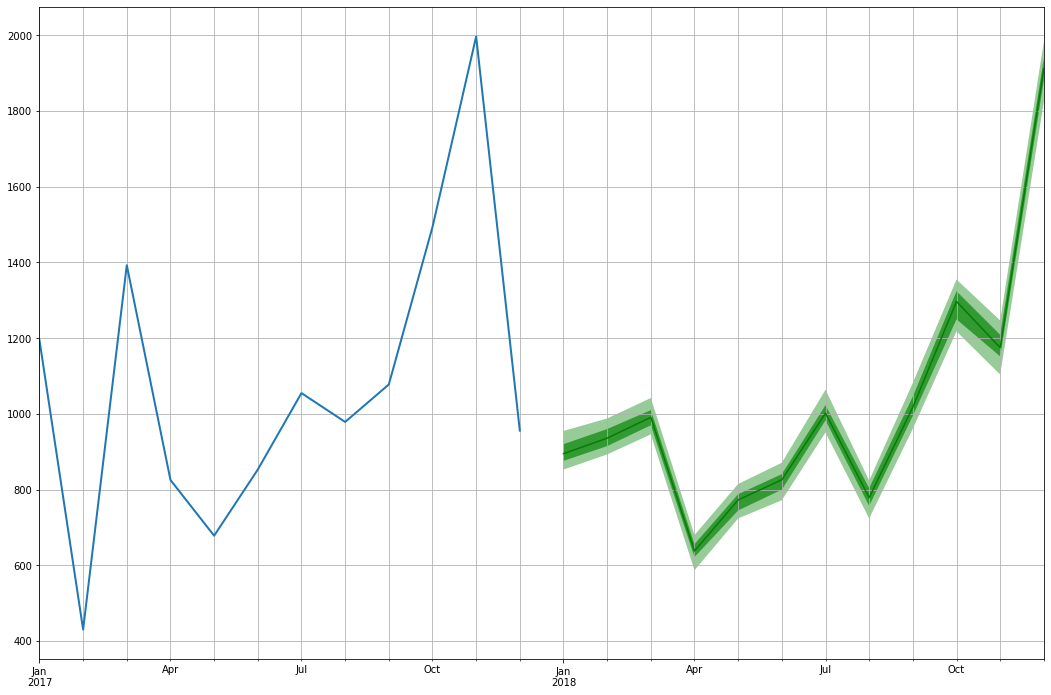

In [47]:
# Vamos plotar o forecast
plot_forecast(predictor = modelo_gluonts_predictor, test_data = test_data)

O forecast parece acompanhar o padrão da série. Vamos avaliar o modelo.

In [48]:
# Previsões com os dados de teste
forecast_it, ts_it = make_evaluation_predictions(dataset = test_data, 
                                                 predictor = modelo_gluonts_predictor, 
                                                 num_samples = 12)

In [49]:
# Extrai as métricas 
metricas_agregadas, metricas_item = Evaluator()(ts_it, forecast_it, num_series = len(test_data))

Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  7.78it/s]


In [51]:
# Visualiza as métricas
metricas_agregadas

{'MSE': 1315580.5833333333,
 'abs_error': 12933.12109375,
 'abs_target_sum': 12933.12109375,
 'abs_target_mean': 1077.7600911458333,
 'seasonal_error': nan,
 'MASE': nan,
 'sMAPE': 2.0,
 'MSIS': nan,
 'QuantileLoss[0.1]': 2586.6242797851564,
 'Coverage[0.1]': 0.0,
 'QuantileLoss[0.2]': 5173.248559570313,
 'Coverage[0.2]': 0.0,
 'QuantileLoss[0.3]': 7759.872839355468,
 'Coverage[0.3]': 0.0,
 'QuantileLoss[0.4]': 10346.497119140626,
 'Coverage[0.4]': 0.0,
 'QuantileLoss[0.5]': 12933.121398925781,
 'Coverage[0.5]': 0.0,
 'QuantileLoss[0.6]': 15519.745678710937,
 'Coverage[0.6]': 0.0,
 'QuantileLoss[0.7]': 18106.369958496092,
 'Coverage[0.7]': 0.0,
 'QuantileLoss[0.8]': 20692.99423828125,
 'Coverage[0.8]': 0.0,
 'QuantileLoss[0.9]': 23279.618518066403,
 'Coverage[0.9]': 0.0,
 'RMSE': 1146.987612545721,
 'NRMSE': 1.0642327749641274,
 'ND': 1.0,
 'wQuantileLoss[0.1]': 0.20000000471929058,
 'wQuantileLoss[0.2]': 0.40000000943858116,
 'wQuantileLoss[0.3]': 0.6000000141578716,
 'wQuantileLoss[0

O RMSE foi bastante alto. Nem mesmo um dos modelos mais avançados da atualidade parece ser suficiente para ajustar essa série. Médias mensais não são a forma ideal de trabalhar com séries temporais, além do fato do volume de dados ser muito baixo.

Vale ressaltar que estamos sendo bem rigorosos na avaliação dos modelos.

O modelo probabilístico autoregressivo, assim como qualquer modelo de Deep Learning, mostra seu brilho quando o volume de dados é realmente alto.

Mas esse modelo DeepAR merece sua atenção. É um dos avanços recentes em Deep Learning.

Como estamos até agora:
    
- Aula 15 --> Modelo ARMA(1,1) - AIC = 550.3, RMSE = 420.2 e MAPE = 29.58
- Aula 16 --> Modelo ARIMA(6,0,2) - AIC = 559.4, RMSE = 401.5 e MAPE = 26.58
- Aula 17 --> Modelo SARIMA(0, 0, 0)x(0, 1, 1, 12) - AIC = 176.74, RMSE = 425.89 e MAPE = 34.95
- Aula 18 --> Modelo SARIMA(1, 1, 0)x(1, 1, 0, 12) - AIC = 146.77, RMSE = 353.57 e MAPE = 30.55
- Aula 19 --> Modelo SARIMA(1, 1, 0)x(1, 1, 0, 12) com exog  - AIC = 149.66, RMSE = 341.23 e MAPE = 32.54
- Aula 20 --> Modelo Prophet 1 - RMSE = 347.58 e MAPE = 28.53
- Aula 21 --> Modelo Prophet 2 - RMSE = 325.52 e MAPE = 26.45
- Aula 22 --> Modelo LSTM Padrão - RMSE = 397.12 e MAPE = 31.46
- Aula 23 --> Modelo Stacked LSTM - RMSE = 396.24 e MAPE = 36.35
- Aula 24 --> Modelo Stacked LSTM Profundo - RMSE = 504.52 e MAPE = 46.35
- Aula 25 --> Modelo Bidirectional LSTM - RMSE = 363.98 e MAPE = 26.15
- Aula 26 --> Modelo DeepAR - RMSE = 1146.98

Não resta mais dúvidas. O modelo Prophet Versão 2 (quando usamos os feriados na Aula 21) foi o nosso campeão. 

E ele será levado para o deploy em produção a partir da próxima aula, para encerrarmos muito bem este curso de Séries Temporais.

# Fim